# Intuit Quickbooks Upgrade

* Team-lead GitLab userid:
* Group name:
* Team member names:

## Setup

Please complete this python notebook with your group by answering the questions in `intuit-redux.pdf`. Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML file from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the second group assignment for MGTA 455 and you will be using Git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's change to accept so the team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `model1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - model1.ipynb, model2.ipynb, model3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/git-group-workflow-wbg.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/zJHwodmjatY
* Dealing with Merge Conflicts: https://youtu.be/qFnyb8_rgTI
* Group assignment practice: https://youtu.be/4Ty_94gIWeA

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import xgboost as xgb
from sklearn import metrics
from pyrsm import profit_max, confusion, profit_plot, gains_plot, lift_plot, ROME_plot
from sklearn.model_selection import RandomizedSearchCV


In [24]:
 mpl.rcParams["figure.dpi"] = 150

In [5]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [6]:
# show dataset description
rsm.describe(intuit75k)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.rds` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software. 

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip: 5-

## Gradient Boosted Trees

### Data Cleaning

In [7]:
intuit75k.zip_bins = intuit75k.zip_bins.astype(object)

In [8]:
intuit75k = intuit75k.join(pd.get_dummies(intuit75k.zip_bins), how='inner')

In [9]:
intuit75k = intuit75k.assign(

    zip801 = (intuit75k['zip'] == '00801').astype(int),
    zip804 = (intuit75k['zip'] == '00804').astype(int)
)

In [10]:
intuit75k.dtypes

id               int32
zip             object
zip_bins        object
sex           category
bizflag          int32
numords          int32
dollars        float64
last             int32
sincepurch       int32
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
1                uint8
2                uint8
3                uint8
4                uint8
5                uint8
6                uint8
7                uint8
8                uint8
9                uint8
10               uint8
11               uint8
12               uint8
13               uint8
14               uint8
15               uint8
16               uint8
17               uint8
18               uint8
19               uint8
20               uint8
zip801           int64
zip804           int64
dtype: object

In [11]:
intuit_train = intuit75k.query('training == 1').reset_index()
intuit_val = intuit75k.query('training == 0').reset_index()

In [12]:
X_train = intuit_train.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index','bizflag'])
y_train = intuit_train[['res1_yes']]
X_test = intuit_val.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index','bizflag'])
y_test = intuit_val[['res1_yes']]

### Fitting the XGBoost Model

In [13]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=123, max_depth=2,n_jobs=6, use_label_encoder=False,reg_lambda=3.9, learning_rate=0.3)
xgb_clf.fit(X_train, y_train.values.ravel(), early_stopping_rounds=100, eval_metric="auc", verbose=True, eval_set=[(X_test, y_test.values.ravel())])

[0]	validation_0-auc:0.66263
[1]	validation_0-auc:0.70723
[2]	validation_0-auc:0.72689
[3]	validation_0-auc:0.72222
[4]	validation_0-auc:0.73195
[5]	validation_0-auc:0.72766
[6]	validation_0-auc:0.72994
[7]	validation_0-auc:0.73743
[8]	validation_0-auc:0.74284
[9]	validation_0-auc:0.75380
[10]	validation_0-auc:0.75251
[11]	validation_0-auc:0.75479
[12]	validation_0-auc:0.75472
[13]	validation_0-auc:0.75820
[14]	validation_0-auc:0.75831
[15]	validation_0-auc:0.76084
[16]	validation_0-auc:0.76181
[17]	validation_0-auc:0.76300
[18]	validation_0-auc:0.76291
[19]	validation_0-auc:0.76288
[20]	validation_0-auc:0.76344
[21]	validation_0-auc:0.76455
[22]	validation_0-auc:0.76529
[23]	validation_0-auc:0.76595
[24]	validation_0-auc:0.76637
[25]	validation_0-auc:0.76593
[26]	validation_0-auc:0.76558
[27]	validation_0-auc:0.76594
[28]	validation_0-auc:0.76618
[29]	validation_0-auc:0.76639
[30]	validation_0-auc:0.76636
[31]	validation_0-auc:0.76620
[32]	validation_0-auc:0.76634
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=6, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=3.9, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
# Prediction probabilities on the test set
pred = xgb_clf.predict_proba(X_test)
probs = pd.Series([p[1] for p in pred])

# Prediction probabilities on the train set
pred_train = xgb_clf.predict_proba(X_train)
probs_train = pd.Series([p[1] for p in pred_train])

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.res1_yes, pred[:,1])
print(f'Test data auc is {metrics.auc(fpr,tpr)}')

Test data auc is 0.7675955115423396


In [16]:
fpr, tpr, thresholds = metrics.roc_curve(y_train.res1_yes, pred_train[:,1])
print(f'Train data auc is {metrics.auc(fpr,tpr)}')

Train data auc is 0.7827163935059891


In [17]:
breakeven = 1.41/30

In [18]:
pred_prof = pd.Series((probs)) 
pred_prof.name = 'predictions_xgb_1_test'

pred_prof_train = pd.Series((probs_train))
pred_prof_train.name = 'predictions_xgb_1_train'

df_test = y_test.join(pred_prof, how='inner')

In [19]:
p = profit_max(df_test,'res1_yes',1,'predictions_xgb_1_test',1.41,30)

print(f'The profit for {xgb_clf} on the test data is ${round(p,3)}')

The profit for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=6, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=3.9, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None) on the test data is $13618.65


In [20]:
TP, FP, TN, FN, contact = confusion(df_test,'res1_yes',1,'predictions_xgb_1_test',1.41,30)

print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')

TP: 747
TN: 15909
FP: 5488
FN: 356


In [21]:
df_test['target_xgb'] = (df_test.predictions_xgb_1_test > breakeven).astype(int)

total_biz = 801821
already_resp = 38487
population = total_biz - already_resp
response_rate_xgb = np.mean(df_test[df_test.target_xgb == 1]['res1_yes'])
targets = population * contact
responses = targets * (response_rate_xgb/2)

In [22]:
cost = targets * 1.41
rev = responses * 60
profit = rev - cost
print(f'The projected profit for the those people who did not respond to wave 1 of mailing but will be mailed a second time is $ {round(profit,2)}')

The projected profit for the those people who did not respond to wave 1 of mailing but will be mailed a second time is $ 462025.71


### Decision Tree Plot

<AxesSubplot:>

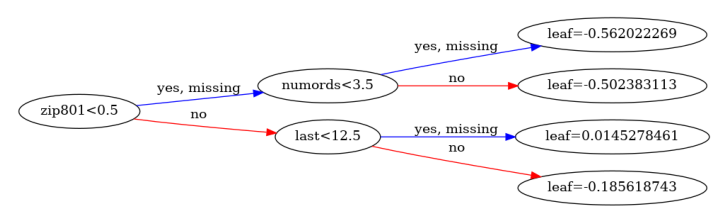

In [26]:
mpl.rcParams["figure.dpi"] = 150
xgb.plot_tree(xgb_clf, rankdir='LR')

### Randomised Search Cross-validation

In [11]:
clf = xgb.XGBClassifier(objective='binary:logistic',seed=123, use_label_encoder=False)

In [107]:
fit_params={"early_stopping_rounds":100, 
            "eval_metric" : "auc", 
            "eval_set" : [(X_test, y_test.values.ravel())]}

In [108]:
gbm_param_grid = {
    'learning_rate': np.arange(0.1, 0.3, 0.05),
    'max_depth': np.arange(1, 4, 1),
    'n_estimators': 1000,
    'reg_lambda':np.arange(3,5,1)
}

In [109]:
from sklearn.metrics import make_scorer

def profit_scoring(y_true, y_pred):
    profit = rsm.profit(pd.Series(y_true), pd.Series(y_pred), 1, 1.41, 30)
    return profit

profit_score = make_scorer(profit_scoring, greater_is_better = True, needs_proba=True)

In [110]:
randomized_roc_auc = RandomizedSearchCV(scoring=profit_score,verbose=1, estimator=clf, param_distributions=gbm_param_grid, n_jobs=6)
randomized_roc_auc.fit(X_train,y_train.values.ravel(),**fit_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-auc:0.67453
[1]	validation_0-auc:0.74596
[2]	validation_0-auc:0.74563
[3]	validation_0-auc:0.74729
[4]	validation_0-auc:0.74921
[5]	validation_0-auc:0.74682
[6]	validation_0-auc:0.74731
[7]	validation_0-auc:0.74853
[8]	validation_0-auc:0.74918
[9]	validation_0-auc:0.74898
[10]	validation_0-auc:0.75153
[11]	validation_0-auc:0.75276
[12]	validation_0-auc:0.75376
[13]	validation_0-auc:0.75977
[14]	validation_0-auc:0.76063
[15]	validation_0-auc:0.76198
[16]	validation_0-auc:0.76276
[17]	validation_0-auc:0.76316
[18]	validation_0-auc:0.76377
[19]	validation_0-auc:0.76444
[20]	validation_0-auc:0.76494
[21]	validation_0-auc:0.76529
[22]	validation_0-auc:0.76458
[23]	validation_0-auc:0.76453
[24]	validation_0-auc:0.76454
[25]	validation_0-auc:0.76469
[26]	validation_0-auc:0.76486
[27]	validation_0-auc:0.76517
[28]	validation_0-auc:0.76513
[29]	validation_0-auc:0.76508
[30]	validation_0-auc:0.76534
[31]	validation_0-a

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
                                           validate_par

In [23]:
df_test

,res1_yes,predictions_xgb_1_test,target_xgb
0,0,0.028346,0
1,0,0.075152,1
2,0,0.024862,0
3,0,0.025639,0
4,0,0.017403,0
...,...,...,...
22495,0,0.032376,0
22496,0,0.016093,0
22497,0,0.121897,1
22498,1,0.146067,1


In [16]:
from sklearn.metrics import make_scorer

def profit_scoring(y_true, y_pred):
    profit = rsm.profit(pd.Series(y_true), pd.Series(y_pred), 1, 1.41, 30)
    return profit

profit_score = make_scorer(profit_scoring, greater_is_better = True, needs_proba=True)

In [17]:
from sklearn.metrics import roc_auc_score

def performance_profit(X_test, y_test, model,model_name, breakeven):
    df_test = pd.DataFrame(X_test, columns=intuit75k_cols)
    df_test['res_y'] = y_test
    df_test['predict_res_proba_'+model_name] = model.predict_proba(X_test)[:,1]
    df_test['predicted_res_'+model_name] = np.where(df_test['predict_res_proba_'+model_name] > breakeven,1,0)
    
    confusion_matrix = pd.crosstab(df_test['res_y'], df_test['predicted_res_'+model_name], margins = True, margins_name = 'Total')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]/2)
    
    profit = rsm.profit_max(df_test, 'res_y',1 ,'predict_res_proba_'+model_name,1.41,30)
    
    print("ROC AUC is {}".format(roc_auc))
    print("Profit is {}".format(profit))
    return roc_auc,profit,confusion_matrix

In [19]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


### EDA, Features

In [20]:
# rsm.distr_plot(intuit75k.loc[:,'zip_bins':])

In [21]:
intuit75k['zip801'] = np.where(intuit75k['zip'] == "00801",1,0)
intuit75k['zip804'] = np.where(intuit75k['zip'] == "00804",1,0)
intuit75k['Res_zip_bin'] = np.where(intuit75k['zip_bins'] == 1,1,0)

In [22]:
def make_version_status(x, y):
    if x == 1 and y == 0:
        return "BoughtV1_CurrentV1"
    if x == 0 and y == 1:
        return "BoughtV1_CurrentV2"
    if x == 0 and y == 0:
        return "BoughtV2_CurrentV2"


intuit75k["version_status"] = intuit75k[["version1", "upgraded"]].apply(
    lambda x: make_version_status(*x), axis=1
)



In [23]:
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,zip801,zip804,Res_zip_bin,version_status
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0,0,0,0,BoughtV2_CurrentV2
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0,0,0,0,BoughtV2_CurrentV2
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0,0,0,0,BoughtV1_CurrentV2
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0,0,0,1,BoughtV2_CurrentV2
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0,0,0,0,BoughtV2_CurrentV2


In [24]:
y = np.array(intuit75k['res1_yes'])
intuit75k_modified = intuit75k.drop(columns=['zip','res1','res1_yes','sex', 'id','training','Res_zip_bin','bizflag','version_status'], axis=1)
intuit75k_modified['zip_bins'] = pd.Categorical(intuit75k_modified['zip_bins'])
intuit75k_modified = pd.get_dummies(intuit75k_modified)
intuit75k_modified.head()


,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,zip801,zip804,zip_bins_1,...,zip_bins_11,zip_bins_12,zip_bins_13,zip_bins_14,zip_bins_15,zip_bins_16,zip_bins_17,zip_bins_18,zip_bins_19,zip_bins_20
0,2,109.5,5,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,69.5,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,93.0,14,29,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,22.0,17,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,24.5,2,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:
intuit75k_cols = list(intuit75k_modified.columns)

X = np.array(intuit75k_modified)

In [26]:
cost= 1.41
margin= 30
breakeven= cost/margin

In [27]:
breakeven

0.047

### Decision Tree  

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

SEED = 123
SEED2 = 168
X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

dt = DecisionTreeClassifier(max_depth=4, random_state=SEED2, min_samples_leaf = 0.14)

MSE_CV = - cross_val_score(dt, X_train, y_train, cv= 10, scoring='neg_mean_squared_error', n_jobs = 4)

dt.fit(X_train,y_train)

y_predict_train = dt.predict(X_train)
y_predict_test = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:,1]
y_pred_proba_train = dt.predict_proba(X_train)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict_test)))
print('CV MSE: {:.2f}'.format(MSE_CV.mean()))
print('Train MSE: {:.2f}'.format(MSE(y_train, y_predict_train)))
print('Test MSE: {:.2f}'.format(MSE(y_test, y_predict_test)))
print('ROC AUC Score Test: {:.2f}'.format(roc_auc_score(y_test, y_pred_proba)))
print('ROC AUC Score Train: {:.2f}'.format(roc_auc_score(y_train, y_pred_proba_train)))

Accuracy: 0.95
CV MSE: 0.05
Train MSE: 0.05
Test MSE: 0.05
ROC AUC Score Test: 0.65
ROC AUC Score Train: 0.66


In [15]:
roc_dt, profit_dt, cm_dt = performance_profit(X_test, y_test, dt, 'dt', breakeven)
cm_dt

ROC AUC is 0.6522815515094926
Profit is 8210.070000000002


predicted_res_dt,0,1,Total
res_y,,,
0,11427,9993,21420
1,300,780,1080
Total,11727,10773,22500


#### Grid Search DT

In [16]:
from sklearn.model_selection import GridSearchCV
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.14,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 168,
 'splitter': 'best'}

In [17]:
params_dt = {'max_depth': [4,5, 6, 7, 8, 9, 10],'min_samples_leaf': [0.2,0.04, 0.06, 0.08, 0.09, 0.1],'max_features': [0.2, 0.4, 0.45, 0.5, 0.6]}

In [18]:
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [19]:
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=4,
                                              min_samples_leaf=0.14,
                                              random_state=168),
             n_jobs=8,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.2, 0.4, 0.45, 0.5, 0.6],
                         'min_samples_leaf': [0.2, 0.04, 0.06, 0.08, 0.09,
                                              0.1]},
             refit='AUC', scoring=make_scorer(profit_scoring, needs_proba=True),
             verbose=5)

In [20]:
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 6, 'max_features': 0.2, 'min_samples_leaf': 0.04}


In [21]:
best_model = grid_dt.best_estimator_

In [22]:
roc_dt, profit_dt, cm_dt = performance_profit(X_test, y_test, best_model , 'dt', breakeven)
cm_dt

ROC AUC is 0.6786716507590691
Profit is 8623.26


predicted_res_dt,0,1,Total
res_y,,,
0,14356,7064,21420
1,430,650,1080
Total,14786,7714,22500


<br>

### Bagging Classifier

In [33]:
%%time
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                    stratify=y,  random_state=SEED, test_size = 0.3)

bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=4, oob_score=True)

bc.fit(X_train, y_train)

y_pred = bc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
oob_accuracy = bc.oob_score_

print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))
print('OOB accuracy: {:.3f}'.format(oob_accuracy))

Accuracy of Bagging Classifier: 0.952
OOB accuracy: 0.952
CPU times: user 2.36 s, sys: 210 ms, total: 2.57 s
Wall time: 6.62 s


In [31]:
roc_bc, profit_bc, cm_bc = performance_profit(X_test, y_test, bc, 'bc', breakeven)
cm_bc

ROC AUC is 0.6550707628730504
Profit is 6275.790000000001


predicted_res_bc,0,1,Total
res_y,,,
0,9163,12257,21420
1,256,824,1080
Total,9419,13081,22500


#### Grid Search BC

In [52]:
from sklearn.model_selection import GridSearchCV
bc.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 4,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 0.14,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 168,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.14, random_state=168),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 300,
 'n_jobs': 4,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [53]:
params_bc = {'base_estimator__min_samples_leaf': [0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8],'base_estimator__max_depth' : [3, 4, 5, 6],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]}

In [54]:
grid_bc = GridSearchCV(estimator=bc,
                       param_grid=params_bc,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [ ]:
grid_bc.fit(X_train, y_train)

In [ ]:
best_hyperparams = grid_bc.best_params_
print('Best hyerparameters:\n', best_hyperparams)

In [ ]:
best_model = grid_bc.best_estimator_

In [ ]:
roc_bcbest, profit_bcbest, cm_bcbest = performance_profit(X_test, y_test, best_model , 'bcbest', breakeven)
cm_bcbest

<br>

### Random Forest

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

SEED = 1234
X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

rf = RandomForestClassifier(n_estimators=400,min_samples_leaf=0.12,random_state=SEED,max_features=3, oob_score=True)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


Test set RMSE of rf: 0.22
CPU times: user 4.67 s, sys: 7.26 ms, total: 4.68 s
Wall time: 4.71 s


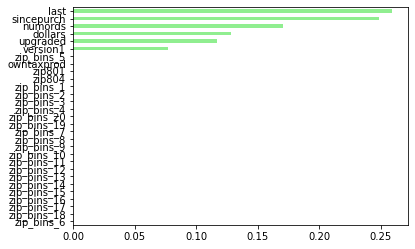

zip_bins_6     0.000000
zip_bins_18    0.000000
zip_bins_17    0.000000
zip_bins_16    0.000000
zip_bins_15    0.000000
zip_bins_14    0.000000
zip_bins_13    0.000000
zip_bins_12    0.000000
zip_bins_11    0.000000
zip_bins_10    0.000000
zip_bins_9     0.000000
zip_bins_8     0.000000
zip_bins_7     0.000000
zip_bins_19    0.000000
zip_bins_20    0.000000
zip_bins_4     0.000000
zip_bins_3     0.000000
zip_bins_2     0.000000
zip_bins_1     0.000000
zip804         0.000000
zip801         0.000000
owntaxprod     0.000000
zip_bins_5     0.000000
version1       0.077323
upgraded       0.116744
dollars        0.128087
numords        0.170145
sincepurch     0.248797
last           0.258904
dtype: float64

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

importances_rf = pd.Series(rf.feature_importances_, index = intuit75k_cols)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='lightgreen'); plt.show()
sorted_importances_rf

In [25]:
roc_rf, profit_rf, cm_rf = performance_profit(X_test, y_test, rf, 'rf', breakeven)
cm_rf

ROC AUC is 0.6770441046789086
Profit is 6504.84


predicted_res_rf,0,1,Total
res_y,,,
0,8413,13007,21420
1,211,869,1080
Total,8624,13876,22500


### Grid Search RF

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.12,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [35]:
params_rf = {'criterion': ['gini', 'entropy'],
     'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800],
            'class_weight': ['balanced', 'balanced_subsample']}

In [36]:
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [ ]:
%%time
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [52]:
randomized_rf = RandomizedSearchCV(estimator=rf,
                       param_distributions=params_rf,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5
                      )
#     scoring="roc_auc",verbose=1, estimator=clf, param_distributions=gbm_param_grid, n_jobs=6)
randomized_rf.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [16082.478       nan       nan 15957.48  15811.716 15781.47        nan
       nan 15905.376 15447.   ]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_features=3,
                                                    min_samples_leaf=0.12,
                                                    n_estimators=400,
                                                    oob_score=True,
                                                    random_state=123),
                   n_jobs=8,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
  

In [53]:
best_hyperparams = randomized_rf.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


In [54]:
best_model_rf = randomized_rf.best_estimator_

In [ ]:
roc_rfbest, profit_rfbest, cm_rfbest = performance_profit(X_test, y_test, best_model_rf , 'rfbest', breakeven)
cm_rfbest

### Stochastic Gradient Boosting (SGB)

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
SEED = 1234

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

sgbt = GradientBoostingClassifier(max_depth=1,
                                 subsample = 0.8,
                                 max_features = 0.5,
                                 n_estimators = 300,
                                 learning_rate = 0.5,
                                 random_state = SEED)

sgbt.fit(X_train, y_train)
y_pred = sgbt.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 0.22


In [36]:
roc_sgbt, profit_sgbt, cm_sgbt= performance_profit(X_test, y_test, sgbt, 'sgbt', breakeven)
cm_sgbt

ROC AUC is 0.7622160191236989
Profit is 12482.25


predicted_res_sgbt,0,1,Total
res_y,,,
0,15856,5564,21420
1,369,711,1080
Total,16225,6275,22500


In [38]:
# Prediction probabilities on the test set
pred = sgbt.predict_proba(X_test)
probs = pd.Series([p[1] for p in pred])

# Prediction probabilities on the train set
pred_train = sgbt.predict_proba(X_train)
probs_train = pd.Series([p[1] for p in pred_train])

In [41]:
y_test = pd.DataFrame(y_test)
pred_prof = pd.Series((probs)) 
pred_prof.name = 'predictions_sgb_test'

pred_prof_train = pd.Series((probs_train))
pred_prof_train.name = 'predictions_sgb_train'

df_test_sgb = y_test.join(pred_prof, how='inner')

In [42]:
df_test_sgb

,0,predictions_sgb_test
0,0,0.011778
1,0,0.040502
2,0,0.009963
3,0,0.087378
4,0,0.023673
...,...,...
22495,0,0.063240
22496,1,0.025929
22497,0,0.065261
22498,0,0.007605


<br>